# 关于新版训练代码 02/17/2022

1. 训练集
    1. winner_poses 原本的skeleton减去了bbox中心
    2. loser_poses 原本的skeleton减去了bbox中心
    3. dists 原本的bbox中心差
    2. 坐标是屏幕坐标系除以1280，720以后的，直接从video_info.npy 提取的
    3. 如果赢家是右边，则反转，保证赢家在左边，输家在右边
    4. Dist是用赢家减输家 （x应该是负的）
    5. 一个视频提取了20帧pose
2. 做了shuffle 和normalization

# to-do 
[v] centered the pose 

[v] draw the prediction around the center

[ ] Result == 1 的时候，为什么不需要反转照片呢？
 因为loser没有用1-自身
 
 
“#loser_tensor_org_restored[:, :, 0] = 1 - loser_tensor_org_restored[:, :, 0]”




In [1]:
import sys
sys.path.append('./Models')
sys.path.append('./Datasets')
sys.path.append('../../')


from Models.interaction_generator import train_fight2, Fight2
from model_helpers import prepare_nd_to_torch, restore_torch_to_nd
from loss_function import compare_two_pose
from crop_pose_image import find_pose_centers, find_bbox, find_pose_centers, get_pose_centered_crop
from extract_videoinfo_poses import mkdir
from FencingAnalysis.BodyframeHelper import draw_keypoints

import torch
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda:0'

In [3]:
def find_bbox(keypoints):
    keypoints_copy = keypoints
    to_delete = []
    cnt = 0
    for kp in keypoints_copy:
        # print(kp.shape)x
        pos = (kp[0], kp[1])
        if (pos == (0, 0)) or (pos == (1, 0)):
            to_delete.append(cnt)
        cnt += 1
    keypoints_copy = np.delete(keypoints_copy, to_delete, 0)
    return [min(keypoints_copy[:, 0]), max(keypoints_copy[:, 0]), min(keypoints_copy[:, 1]), max(keypoints_copy[:, 1])]

def get_dist_grid(dist_ref, grid_dim=[30, 1], offsets=[0, 0]):
    dist_grid = torch.zeros([grid_dim[0], grid_dim[1], 2]).to(device)
    offsetX = torch.tensor([offsets[0], 0.0]).float().to(device)
    offsetY = torch.tensor([0.0, offsets[1]]).float().to(device)
    for i in range(grid_dim[0]):
        for j in range(grid_dim[1]):
            dist_grid[i, j, :] = dist_ref + \
                                 offsetX * (i - int((grid_dim[0]) / 2)) + \
                                 offsetY * (j - int((grid_dim[1]) / 2))

    return dist_grid

def bbox_center(bbox):
    return ((bbox[0] + bbox[1])/2, (bbox[2] + bbox[3])/2)

def bbox_dists(bbox1, bbox2):
    return (np.array(bbox_center(bbox1)) - np.array(bbox_center(bbox2)))

In [4]:
### Load the entire dataset

npys = glob.glob(f"/media/weihao/UNTITLED/tokyo_olymics/datasets/olympic_batch_2v3/npys/*")
winner_poses = []
winner_centers = []
loser_poses = []
loser_centers = []
dists = []
results = []
frame_indices = []
for v in range(len(npys)):
    npy = np.load(npys[v])
    result = npy['round_result']
    score_moment = npy['decisive_frame_index']
    skeleton_frames = npy['skeleton_frames']
    if (score_moment - 10) > 0 and (score_moment + 10) <= len(skeleton_frames):
        flag = True
        for i in range(score_moment - 10, (score_moment + 10)):
            if len(skeleton_frames[i]) != 2:
                flag = False
        if flag == True:
            for i in range(score_moment - 10, (score_moment + 10)):
                winner_pose = np.array(skeleton_frames[i][result])
                loser_pose = np.array(skeleton_frames[i][1-result])
    #             print(loser_pose, winner_pose.shape)
                # when the right side wins, flip both players across the screen
                if result == 1:
                    loser_pose[:, 0] = 1 - loser_pose[:, 0] 
                    winner_pose[:, 0] = 1 - winner_pose[:, 0]
                winner_bbox = find_bbox(winner_pose)
                loser_bbox = find_bbox(loser_pose)
                dists.append(bbox_dists(winner_bbox, loser_bbox))
                
                winner_center = [(winner_bbox[0] + winner_bbox[1])/2, (winner_bbox[2] + winner_bbox[3])/2, 0]
                loser_center = [(loser_bbox[0] + loser_bbox[1])/2, (loser_bbox[2] + loser_bbox[3])/2, 0]
                winner_centers.append(winner_center)
                loser_centers.append(loser_center)
#                 print(winner_pose, winner_center)                
                winner_pose = winner_pose - winner_center
                loser_pose = loser_pose - loser_center
#                 print(winner_pose)
                winner_poses.append(winner_pose)
                loser_poses.append(loser_pose)
                results.append(result)
                
                frame_indices.append([int(npys[v].split('/')[-1].split('_')[0]), i])

dists = np.array(dists)
winner_poses = np.array(winner_poses)
loser_poses = np.array(loser_poses)
frame_indices = np.array(frame_indices)
winner_centers = np.array(winner_centers)
loser_centers = np.array(loser_centers)
results = np.array(results)

print(dists.shape)
print(winner_poses.shape)
print(loser_poses.shape)
print(frame_indices.shape)
print(frame_indices)

(5400, 2)
(5400, 25, 3)
(5400, 25, 3)
(5400, 2)
[[  2 102]
 [  2 103]
 [  2 104]
 ...
 [444 278]
 [444 279]
 [444 280]]


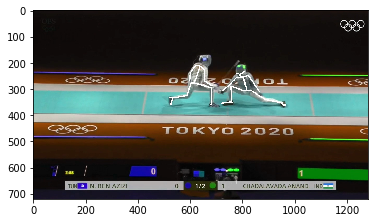

In [5]:
begin = 10
(video_index, frame_count) = frame_indices[begin]
WORK_PATH='/media/weihao/UNTITLED/tokyo_olymics'
image = cv2.imread(f"{WORK_PATH}/datasets/olympic_batch_2v3/video_frames/{video_index:05d}/{frame_count:05d}.jpg")
plt.imshow(image)
image = draw_keypoints(image, (winner_poses[begin: begin + 1].reshape(25,3) + winner_centers[begin: begin + 1]) * np.array([1280, 720, 1]), draw_confidence = False)
image = draw_keypoints(image, (loser_poses[begin: begin + 1].reshape(25,3)+ loser_centers[begin: begin + 1]) * np.array([1280, 720, 1]), draw_confidence = False)
plt.imshow(image)

In [6]:
### Prepare Dataset

# Pick only parts of the dataset
pick_indices = np.array([np.array(range(int(winner_poses.shape[0]/20))) * 20 + i for i in range(5, 15)])
pick_indices = np.transpose(pick_indices).flatten()

# Filter out the picked dataset
winner_poses_used = winner_poses[pick_indices]
loser_poses_used = loser_poses[pick_indices]
dists_used = dists[pick_indices]
frame_indices_used = frame_indices[pick_indices]
winner_centers_used = winner_centers[pick_indices]
loser_centers_used = loser_centers[pick_indices]
results_used = results[pick_indices]
SHOULD_SHUFFLE = True

# Shuffle the combined tensor
shuffle_indices = np.arange(winner_poses_used.shape[0])
if SHOULD_SHUFFLE:
    np.random.shuffle(shuffle_indices)

winner_poses_shuffled = winner_poses_used[shuffle_indices]
loser_poses_shuffled = loser_poses_used[shuffle_indices]
dists_used_shuffled = dists_used[shuffle_indices]

# Create tensors & normailization 
winner_std, winner_mean, winner_tensor = prepare_nd_to_torch(winner_poses_shuffled)
loser_std, loser_mean, loser_tensor = prepare_nd_to_torch(loser_poses_shuffled)
# dist_std, dist_mean, dist_tensor = prepare_nd_to_torch(dists_used_shuffled)

dists_tensor = torch.from_numpy(dists_used_shuffled).to(device)
dist_std, dist_mean = torch.std_mean(dists_tensor, dim=0)
dists_tensor = (dists_tensor - dist_mean) / dist_std

36


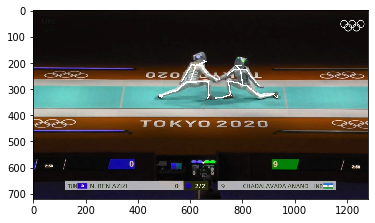

In [7]:
### Test Shuffuled Dataset

begin = 160
idx = shuffle_indices[begin]
print(idx)
(video_index, frame_count) = frame_indices_used[idx]

image = cv2.imread(f"/media/weihao/UNTITLED/tokyo_olymics/datasets/olympic_batch_2v3/video_frames/{video_index:05d}/{frame_count:05d}.jpg")
plt.imshow(image)
image = draw_keypoints(image, (winner_poses_shuffled[begin: begin + 1].reshape(25,3) + winner_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)
image = draw_keypoints(image, (loser_poses_shuffled[begin: begin + 1].reshape(25,3)+ loser_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)
plt.imshow(image)

In [9]:
### Train Model

IDENTIFIER = "1.01_fight_test"
WORK_PATH='/media/weihao/UNTITLED/tokyo_olymics'
epochs = 200
model_save_dir = f"{WORK_PATH}/saved_models/{IDENTIFIER}"
visualization_save_dir = f"{WORK_PATH}/recon_results/{IDENTIFIER}"
mkdir(model_save_dir)
mkdir(visualization_save_dir)
# Train & Save the model
# fight_model = train_fight2([loser_tensor, winner_tensor], dists_tensor,
#                            loss_func=compare_two_pose,
#                            epoch=epochs,
#                            batch_size=32,
#                            lr=0.03,
#                            l2_lamda=0.001,
#                            save_models=True,
#                            save_path=f"{model_save_dir}/fight_")

In [10]:
### Read 10 model checkpoints

E = [1]
for i in range(10):
    E.append(int(epochs* (0.1 * i + 0.1)))
print(E)
model_save_dir = f"{WORK_PATH}/saved_models/{IDENTIFIER}"
visualization_save_dir = f"{WORK_PATH}/recon_results/{IDENTIFIER}"
mkdir(visualization_save_dir)
models = [torch.load(f"{model_save_dir}/fight_{(e):04d}.pth") for e in E]

[1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]




0 2364 392 155
0 1678 285 519
0 873 128 795
0 160 40 57
0 2397 395 53
0 954 151 118
0 334 65 165
0 2105 349 366
0 338 65 169
0 775 116 57
0 1689 286 78
0 1624 279 87
0 570 93 148
0 1950 326 59
0 541 90 302
0 921 141 77
0 564 92 331
0 1810 305 141
0 649 102 73
0 1404 252 46
0 2370 393 31
0 822 122 300


/home/weihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0 1195 196 1019
0 773 116 55
0 630 100 103
0 1612 278 496
0 1517 266 118


KeyboardInterrupt: 

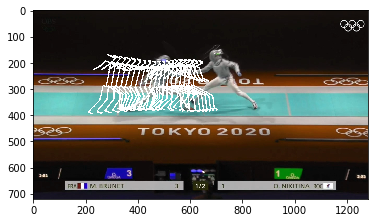

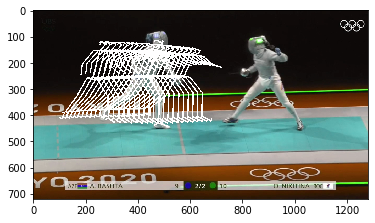

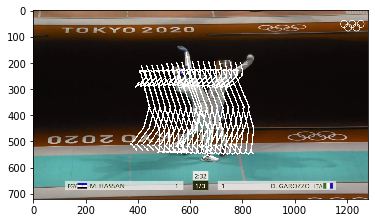

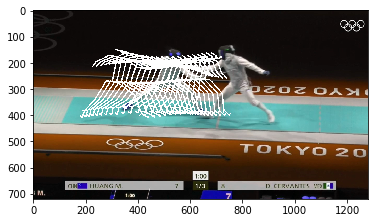

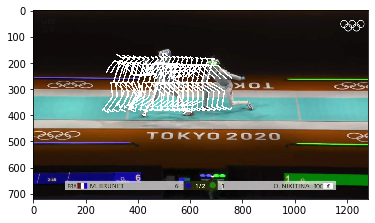

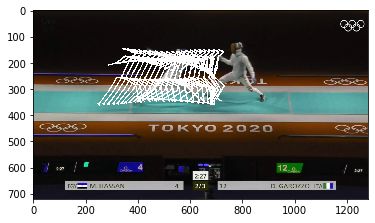

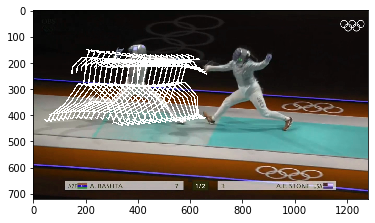

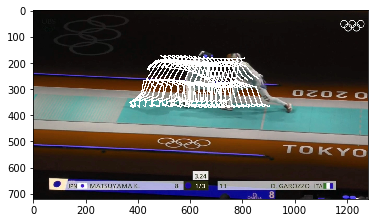

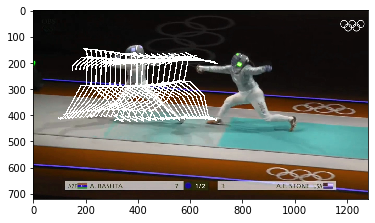

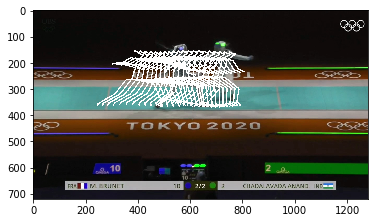

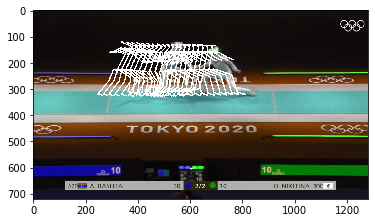

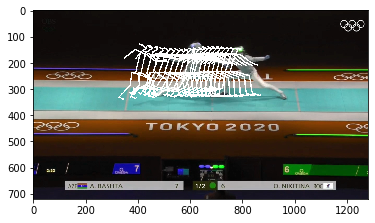

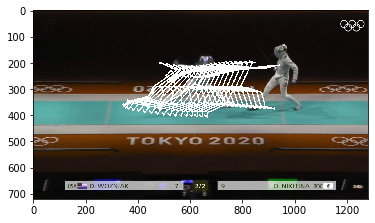

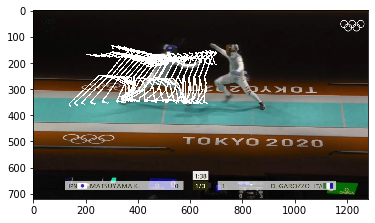

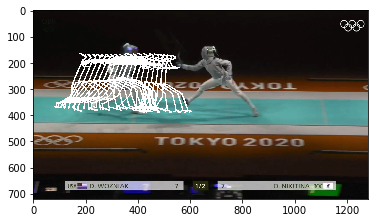

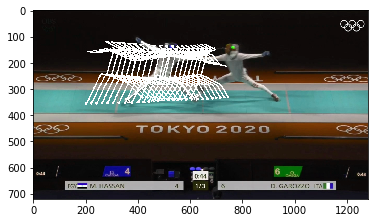

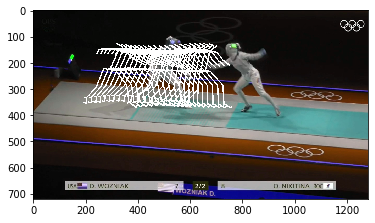

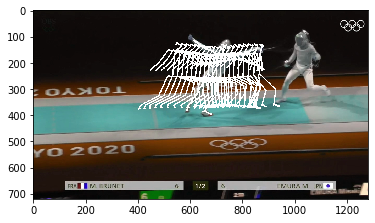

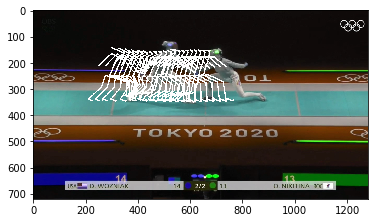

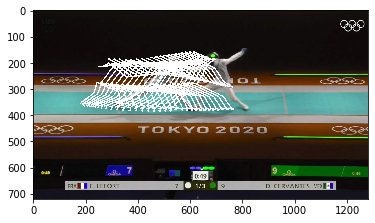

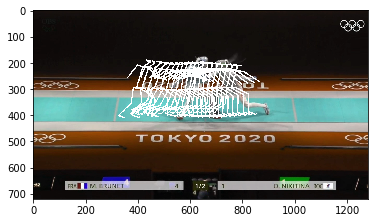

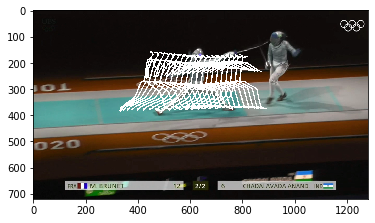

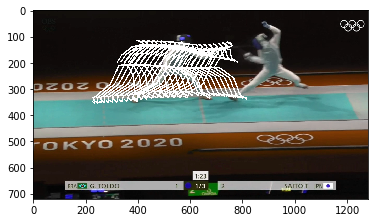

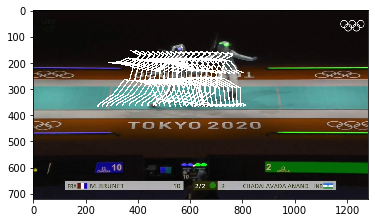

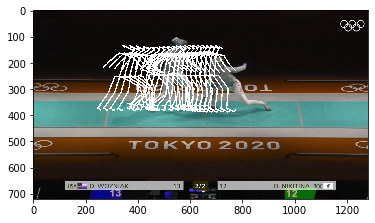

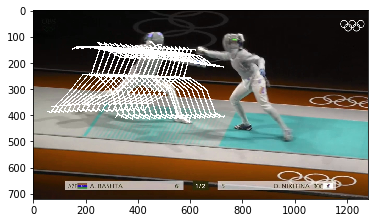

In [11]:
grid_dim = [20, 1]
offsets = [0.015, 0.0]
save_path = f"{visualization_save_dir}/combat_synthesis"  # {video_index:05d}/"
mkdir(save_path)
for fight_model in models[8:9]:
    for i in range(0,100):
        idx = shuffle_indices[i]
        
        loser_pose_tensor = loser_tensor[i:i + 1]
        dist_grid = get_dist_grid(torch.from_numpy(dists_used[idx]).to(device), grid_dim=grid_dim, offsets=offsets)
        dist_grid_normalized = (dist_grid - dist_mean)/dist_std
        winner_tensor_recon_restored_multi = []
        for x in range(grid_dim[0]):
            for y in range(grid_dim[1]):
                dist = dist_grid_normalized[x, y].reshape(1, 2)
                winner_tensor_recon = fight_model(loser_pose_tensor.float(), dist.float())
                winner_tensor_recon_restored = restore_torch_to_nd(winner_tensor_recon, winner_std, winner_mean)
                winner_tensor_recon_restored_multi.append(winner_tensor_recon_restored)
        winner_tensor_recon_restored_multi = np.stack(winner_tensor_recon_restored_multi)

        loser_tensor_org_restored = restore_torch_to_nd(loser_pose_tensor, loser_std, loser_mean)
    #     loser_tensor_org_restored[:, :, 0] = 1 - loser_tensor_org_restored[:, :, 0]
        winner_tensor_org_restored = restore_torch_to_nd(winner_tensor[i:i + 1], winner_std, winner_mean)


        (video_index, frame_count) = frame_indices_used[idx]
#         print((video_index, frame_count))
        original_image = cv2.imread(f"{WORK_PATH}/datasets/olympic_batch_2v3/video_frames/{video_index:05d}/{frame_count:05d}.jpg")
        print(results[idx], idx, video_index, frame_count)
#         if results[idx] == 1:
#             original_image = cv2.flip(original_image, 1)
# # Show original image       
#         plt.figure()
#         plt.imshow(original_image)    

# # Show original winner loser image
#         image = draw_keypoints(np.copy(original_image), (winner_poses_used[idx: idx + 1].reshape(25,3) + winner_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)
#         image = draw_keypoints(image, (loser_poses_used[idx: idx + 1].reshape(25,3) + loser_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)
#         plt.figure()
#         plt.imshow(image)

# # Show loser-restored image, check about the std and mean
#         loser_tensor_org_restored_screen_space = (loser_tensor_org_restored.reshape(25, -1)+ loser_centers_used[idx:idx+1]) * np.array([1280,720, 1.0])
#         image = draw_keypoints(np.copy(original_image), loser_tensor_org_restored_screen_space.reshape(25,-1), draw_confidence = False)
#         plt.figure()
#         plt.imshow(image)


        
# # Show multiple predictions
        image = np.copy(original_image)
        image = draw_keypoints(image, (winner_poses_used[idx: idx + 1].reshape(25,3) + winner_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)


        winner_centers_aggregated = loser_centers_used[idx, 0:2] + dist_grid.detach().cpu().numpy()
#         winner_center_original = loser_centers_used[idx, 0:2] - dists_used[idx]
#         print(winner_centers_aggregated, winner_center_original)
        generated_winner_pose_screen_space = (winner_tensor_recon_restored_multi.reshape(-1,25, 2) + winner_centers_aggregated) * np.array([1280,720])

        for didx in range(grid_dim[0]):
#             print(generated_winner_pose_screen_space[didx])
            image = draw_keypoints(image, generated_winner_pose_screen_space[didx].reshape(25,-1) , draw_confidence = False)
        plt.figure()
        plt.imshow(image)
        
        cv2.imwrite(save_path + f"/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}.jpg", image)

In [12]:
# find the idx of given video and frame
video_idx = 294
frame_idx = 547
for idx_t in range(frame_indices_used.shape[0]):
    if (frame_indices_used[idx_t, :] ==  (video_idx, frame_idx)).all(): 
        idx = idx_t
        print(idx_t)
        
# find i in the shuffle_indices        
i = int(np.argwhere(shuffle_indices == idx))
print(i, idx)

1738
683 1738


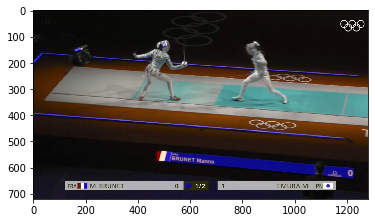

In [13]:
original_image = cv2.imread(f"{WORK_PATH}/datasets/olympic_batch_2v3/video_frames/{video_idx:05d}/{frame_idx:05d}.jpg")
cv2.imwrite(f"{save_path}/{video_index:05d}_{frame_count:05d}.jpg", original_image)
plt.figure()
plt.imshow(original_image)


In [14]:
generated_winner_pose_screen_space[didx].shape

(25, 2)

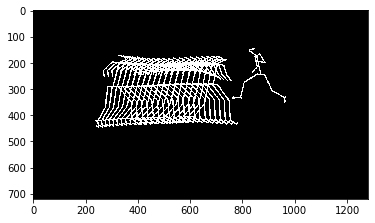

In [21]:
fight_model = models[8]

grid_dim = [20, 1]
offsets = [0.015, 0.0]
save_path = f"./for_psp/{video_idx:05d}_{frame_idx:05d}"  # {video_index:05d}/"
mkdir(save_path)
mkdir(f"{save_path}/crops/")
mkdir(f"{save_path}/replaced_crops/")
      
loser_pose_tensor = loser_tensor[i:i + 1]
dist_grid = get_dist_grid(torch.from_numpy(dists_used[idx]).to(device), grid_dim=grid_dim, offsets=offsets)
dist_grid_normalized = (dist_grid - dist_mean)/dist_std
winner_tensor_recon_restored_multi = []
for x in range(grid_dim[0]):
    for y in range(grid_dim[1]):
        dist = dist_grid_normalized[x, y].reshape(1, 2)
        winner_tensor_recon = fight_model(loser_pose_tensor.float(), dist.float())
        winner_tensor_recon_restored = restore_torch_to_nd(winner_tensor_recon, winner_std, winner_mean)
        winner_tensor_recon_restored_multi.append(winner_tensor_recon_restored)
winner_tensor_recon_restored_multi = np.stack(winner_tensor_recon_restored_multi)

loser_tensor_org_restored = restore_torch_to_nd(loser_pose_tensor, loser_std, loser_mean)
#     loser_tensor_org_restored[:, :, 0] = 1 - loser_tensor_org_restored[:, :, 0]
winner_tensor_org_restored = restore_torch_to_nd(winner_tensor[i:i + 1], winner_std, winner_mean)

(video_index, frame_count) = frame_indices_used[idx]


# # Show multiple predictions
# image = draw_keypoints(image, (winner_poses_used[idx: idx + 1].reshape(25,3) + winner_centers_used[idx:idx+1]) * np.array([1280, 720, 1]), draw_confidence = False)


winner_centers_aggregated = loser_centers_used[idx, 0:2] + dist_grid.detach().cpu().numpy()
#         winner_center_original = loser_centers_used[idx, 0:2] - dists_used[idx]
#         print(winner_centers_aggregated, winner_center_original)
generated_winner_pose_0_1_space = winner_tensor_recon_restored_multi.reshape(-1,25, 2) + winner_centers_aggregated

image_all = np.zeros(shape = [720, 1280, 3], dtype=np.uint8)
for didx in range(grid_dim[0]):
#             print(generated_winner_pose_screen_space[didx])
    image = np.zeros(shape = [720, 1280, 3], dtype=np.uint8)
    image = draw_keypoints(image, generated_winner_pose_screen_space[didx].reshape(25,-1) , draw_confidence = False)
    image_all = draw_keypoints(image_all, generated_winner_pose_screen_space[didx].reshape(25,-1) , draw_confidence = False)
    
    crop, _, _, _ = get_pose_centered_crop(image, generated_winner_pose_0_1_space[didx])
#     plt.figure()
#     plt.imshow(crops[0])
    cv2.imwrite(f"{save_path}/crops/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}_{didx:04d}_crop.jpg", crop)    
#     plt.figure()
#     plt.imshow(image)
    cv2.imwrite(f"{save_path}/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}_{didx:04d}.jpg", image)
    
loser_tensor_org_restored_screen_space = (loser_tensor_org_restored.reshape(25, -1)+ loser_centers_used[idx:idx+1]) * np.array([1280,720, 1.0])
image_all= draw_keypoints(image_all, loser_tensor_org_restored_screen_space.reshape(25,-1), draw_confidence = False)
cv2.imwrite(f"{save_path}/crops/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}_all.jpg", image_all)
plt.figure()
plt.imshow(image_all)



In [48]:
def replace_centered_crop(frame, pose, side_to_replace, patch, opacity = 1):    
    center, pose_centered, bbox = find_pose_centers(pose * np.array([1280, 720]))
    print(bbox)
    i = side_to_replace
    crop_size = int(max((bbox[1] - bbox[0]), (bbox[3] - bbox[2])) * 0.8) * 2 
    
    crop = cv2.resize(patch, (crop_size, crop_size), interpolation=cv2.INTER_AREA)
    frame_bbox = [
        int(max(0, center[0] - crop_size / 2)),
        int(min(frame.shape[1], center[0] + crop_size / 2)),
        int(max(0, center[1] - crop_size / 2)),
        int(min(frame.shape[0], center[1] + crop_size / 2))
    ]
    offseted_bbox = [
        int(max(frame.shape[1], center[0] + crop_size / 2)) - frame.shape[1],
        crop_size - int(-min(0, center[0] - crop_size / 2)),
        int(max(frame.shape[0], center[1] + crop_size / 2)) - frame.shape[0],
        crop_size - int(-min(0, center[1] - crop_size / 2))
    ]
    print(offseted_bbox)

    background_img_float = np.ones((frame_bbox[3]-frame_bbox[2], frame_bbox[1]-frame_bbox[0], 4), dtype=np.float)
    background_img_float = background_img_float * 255
    background_img_float[:,:,0:3] = frame[frame_bbox[2]:frame_bbox[3], frame_bbox[0]:frame_bbox[1], :]


    foreground_img_float = np.ones((offseted_bbox[3]-offseted_bbox[2], offseted_bbox[1]-offseted_bbox[0], 4), dtype=np.float)
    print(foreground_img_float.shape)


    foreground_img_float = background_img_float * 255
    foreground_img_float[:,:,0:3] = crop[offseted_bbox[2]:offseted_bbox[3], offseted_bbox[0]:offseted_bbox[1], :]

    # opacity = 1  # The opacity of the foreground that is blended onto the background is 70 %.
#     blended_img_float = blend_modes.lighten_only(background_img_float, foreground_img_float, opacity)
    frame[frame_bbox[2]:frame_bbox[3], frame_bbox[0]:frame_bbox[1], :] = foreground_img_float[:, :, 0:3]
    return frame

In [40]:
###

# Run the other program first
# ----- Running the PSP model to generate image patches------

###

In [49]:
# Add black background to the psp-transferred image

cnt = 0
for didx in range(grid_dim[0]):
    pose = generated_winner_pose_0_1_space[didx]
    canvas = np.zeros(shape=[720, 1280, 3], dtype=np.uint8)

#     crop, _, _, _ = get_pose_centered_crop(image, generated_winner_pose_0_1_space[didx])

    img = cv2.imread(f"{save_path}/inference_results/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}_{didx:04d}_crop.jpg")
#     print(img.shape)
    #     img = cv2.resize(img, dsize=(256, 256))
    canvas = replace_centered_crop(canvas, pose, 0, img, opacity=1)
    
    cv2.imwrite(f"{save_path}/replaced_crops/{video_index:05d}_{frame_count:05d}_{offsets}_{grid_dim}_{didx:04d}_replaced_crop.jpg", canvas)

#     print(didx)
#     plt.figure()
#     plt.imshow(canvas)

[204.47257630920404, 422.8948365936279, 96.31915715575221, 366.8294527852535]
[0, 432, 0, 432]
(432, 432, 4)
[219.81741540527338, 443.2360708007812, 99.29034736990931, 364.4386067712307]
[0, 424, 0, 424]
(424, 424, 4)
[234.5894872436523, 463.65440957641596, 102.54757908225062, 361.8458655202389]
[0, 414, 0, 414]
(414, 414, 4)
[248.794675994873, 484.06414620971674, 106.1426081979275, 359.03562930464744]
[0, 404, 0, 404]
(404, 404, 4)
[262.04391114807123, 504.3344938049316, 110.13692167639735, 355.99366095900535]
[0, 392, 0, 392]
(392, 392, 4)
[274.52371232604975, 524.2575895080565, 114.58227542281153, 352.7230396592617]
[0, 398, 0, 398]
(398, 398, 4)
[286.9909822235107, 543.5105573425292, 119.4881322705746, 349.2718198621273]
[0, 410, 0, 410]
(410, 410, 4)
[300.1785051116943, 561.6337930450438, 124.78759792685511, 345.76063660025596]
[0, 418, 0, 418]
(418, 418, 4)
[315.0239717254638, 578.0746518859862, 130.31631735205653, 343.3843174302578]
[0, 420, 0, 420]
(420, 420, 4)
[332.3998700866